In [1]:
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io

import pandas as pd

---------------------- SCIANN 0.6.0.4 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [30]:
def PrepareData(num_data=5000, random=True,ts_max=100):
    
    # Get data file from: 
    #         https://github.com/maziarraissi/PINNs/tree/master/main/Data/cylinder_nektar_wake.mat
    data = scipy.io.loadmat('cylinder_nektar_wake.mat')
    
    U_star = data['U_star'][:,:,:ts_max] # N x 2 x T = 5000 x 2 x 200
    P_star = data['p_star'][:,:ts_max] # N x T = 5000 x 200
    t_star = data['t'][:ts_max] # T x 1 = 200 x 1
    X_star = data['X_star'] # N x 2 = 5000 x 1
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T))[:,:ts_max] # N x T
    YY = np.tile(X_star[:,1:2], (1,T))[:,:ts_max] # N x T
    TT = np.tile(t_star, (1,N)).T[:,:ts_max] # N x T
    
    UU = U_star[:,0,:ts_max] # N x T
    VV = U_star[:,1,:ts_max] # N x T
    PP = P_star[:,:ts_max] # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)

In [31]:
x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, random=True)

In [32]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

In [33]:
P = sn.Functional("P", [x, y, t], 8*[20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], 8*[20], 'tanh')

In [34]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

In [35]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

In [36]:
# Define constraints 
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)

In [37]:
c4 = Psi*0.0

In [38]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse",
    plot_to_file='NS-Model.png'
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [39]:
input_data = [x_train, y_train, t_train]

In [40]:
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

In [41]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=1000,
    batch_size=100,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)

model.save_weights('trained-navier-stokes_short.hdf5')

Grad__11_loss: 1.4186e-04 - mul_13_loss: 1.0730e-04 - P_loss: 3.3891e-05 - sub_6_loss: 1.3572e-04 - sub_8_loss: 1.1954e-04 - add_14_loss: 2.7512e-32 - mul_24_loss: 0.0000e+00
Epoch 928/1000
5000/5000 [==============================] - 1s 190us/sample - loss: 4.7798e-04 - Grad__11_loss: 1.2667e-04 - mul_13_loss: 8.7104e-05 - P_loss: 3.1299e-05 - sub_6_loss: 1.2803e-04 - sub_8_loss: 1.0488e-04 - add_14_loss: 2.5816e-32 - mul_24_loss: 0.0000e+00
Epoch 929/1000
5000/5000 [==============================] - 1s 198us/sample - loss: 5.1558e-04 - Grad__11_loss: 1.3457e-04 - mul_13_loss: 9.0548e-05 - P_loss: 3.2817e-05 - sub_6_loss: 1.3921e-04 - sub_8_loss: 1.1844e-04 - add_14_loss: 2.8181e-32 - mul_24_loss: 0.0000e+00
Epoch 930/1000
5000/5000 [==============================] - 1s 189us/sample - loss: 6.0246e-04 - Grad__11_loss: 1.4750e-04 - mul_13_loss: 1.0402e-04 - P_loss: 4.2414e-05 - sub_6_loss: 1.5903e-04 - sub_8_loss: 1.4949e-04 - add_14_loss: 2.7486e-32 - mul_24_loss: 0.0000e+00
Epoch 931

In [123]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

lambda1: [0.99734237],  lambda2: [0.01017379]


Text(0, 0.5, 'loss')

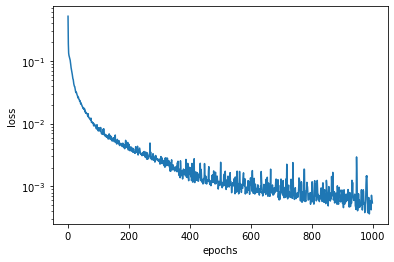

In [43]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [13]:
data = scipy.io.loadmat('cylinder_nektar_wake.mat')

In [44]:
ts_max = 200

U_star = data['U_star'][:,:,:ts_max] # N x 2 x T = 5000 x 2 x 200
P_star = data['p_star'][:,:ts_max] # N x T = 5000 x 200
t_star = data['t'][:ts_max] # T x 1 = 200 x 1
X_star = data['X_star'] # N x 2 = 5000 x 1
    
N = X_star.shape[0]
T = t_star.shape[0]
    
# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T))[:,:ts_max] # N x T
YY = np.tile(X_star[:,1:2], (1,T))[:,:ts_max] # N x T
TT = np.tile(t_star, (1,N)).T[:,:ts_max] # N x T
    
UU = U_star[:,0,:ts_max] # N x T
VV = U_star[:,1,:ts_max] # N x T
PP = P_star[:,:ts_max] # N x T

In [67]:
# Test data : All the data 
test_data = [XX,YY,TT]

In [68]:
# Predictions
preds = model.predict(test_data)

u_preds = preds[0]
v_preds = preds[1]
p_preds = preds[2]

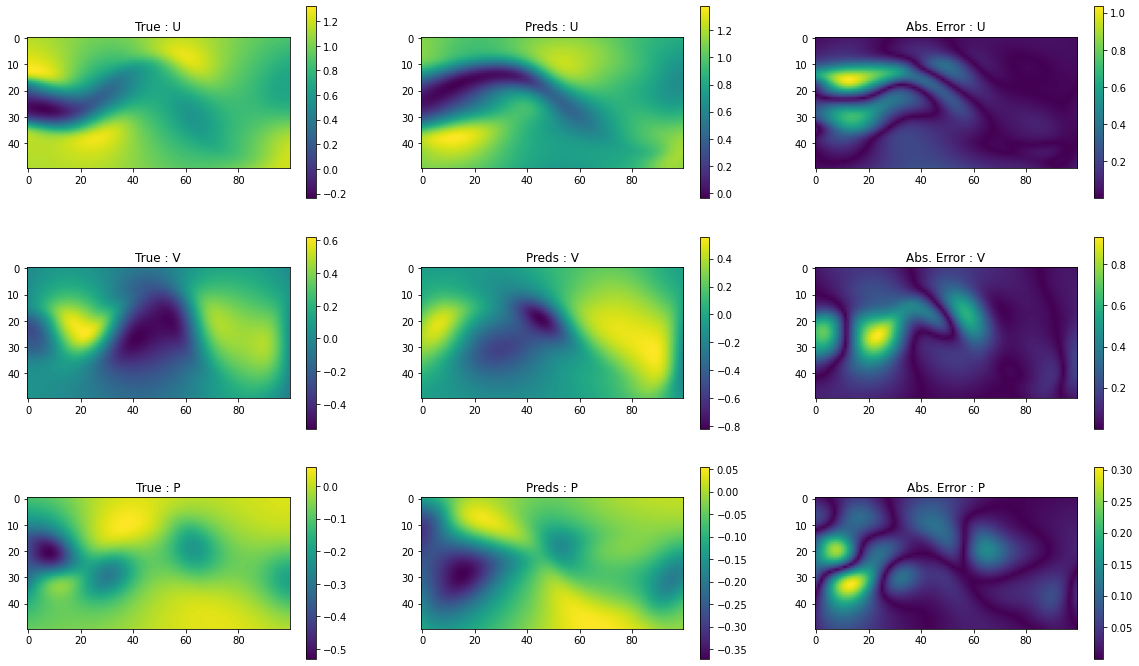

In [122]:
time_step_selected = 130

columns = ['X','Y','U','V','P']

# True values dataframe
df = pd.DataFrame(columns=columns)
for _i, param in enumerate([XX,YY,UU,VV,PP]):
    df[columns[_i]] = param[:,time_step_selected] # we select the timestep here (param[:,timestep])

# Pred values dataframe
df_preds = pd.DataFrame(columns=columns)
for _i, param in enumerate([x_test,y_test,u_preds,v_preds,p_preds]):
    df_preds[columns[_i]] = param[:,time_step_selected]

# Plot
fig, axs = plt.subplots(3,3,figsize=(20,12))


for _i, param in zip(range(3), ['U','V','P']):
    df_clean = df.pivot(values=param,columns='X',index='Y')
    im = axs[_i,0].imshow(df_clean.values)
    axs[_i,0].set_title("True : " + param)
    plt.colorbar(im,ax = axs[_i,0])

    df_clean_preds = df_preds.pivot(values=param,columns='X',index='Y')
    im = axs[_i,1].imshow((df_clean_preds.values))
    axs[_i,1].set_title("Preds : " + param)
    plt.colorbar(im,ax = axs[_i,1])

    im = axs[_i,2].imshow(np.abs((df_clean_preds.values-df_clean.values)))
    axs[_i,2].set_title("Abs. Error : " + param)
    plt.colorbar(im,ax = axs[_i,2])

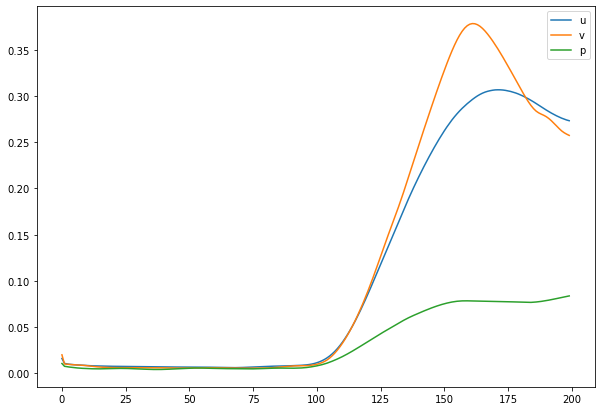

In [127]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(np.mean(np.abs((UU - u_preds)),axis=0),label='u')
ax.plot(np.mean(np.abs((VV - v_preds)),axis=0),label='v')
ax.plot(np.mean(np.abs((PP - p_preds)),axis=0),label='p')
plt.legend()

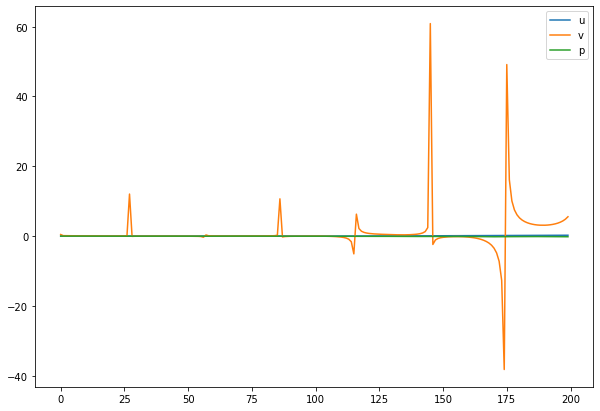

In [132]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(np.abs(np.mean(UU,axis=0) - np.mean(u_preds,axis=0))/np.mean(UU,axis=0),label='u')
ax.plot(np.abs(np.mean(VV,axis=0) - np.mean(v_preds,axis=0))/np.mean(VV,axis=0),label='v')
ax.plot(np.abs(np.mean(PP,axis=0) - np.mean(p_preds,axis=0))/np.mean(PP,axis=0),label='p')
plt.legend()